# MNIST Camera Demo
This is a simple demo that uses camera to capture handwritten digits and recognize them using hardware accelerated neural network.

In [1]:
!pip3 install bitstring

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from processing import process_image

Helper procedure:

In [3]:
def image_capture():
    cam = cv2.VideoCapture(0)
    if not cam.isOpened():
        print("Error opening camera")
        return False, None

    ret = cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    ret &= cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    if not ret:
        print("Error setting resolution")
        return False, None

    ret, frame = cam.read()

    cam.release()

    return ret, frame


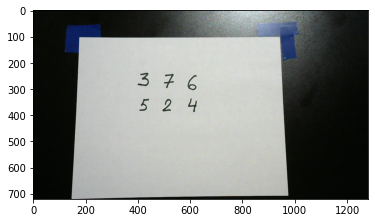

In [4]:
ret, frame = image_capture()
if not ret:
    print("Failed to capture frame")

%matplotlib inline
plt.imshow(frame[:,:,[2,1,0]])
plt.show()

In [5]:
input_array = process_image(frame, debug=False)
print(f"Processed array shape: {input_array.shape}")

Processed array shape: (6, 784)


Let's print one of the recognized (28x28) images:

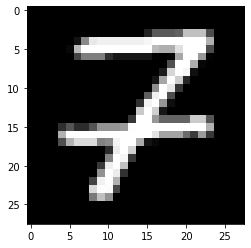

In [6]:
x = input_array[1]
plt.imshow(x.reshape(28,28), cmap='gray')

In [7]:
from qonnx.core.datatype import DataType
from mnist_overlay import MNISTOverlay
from pynq.pl_server.device import Device

batch_size = len(input_array)

accel = MNISTOverlay(bitfile_name="resizer.bit", batch_size=batch_size)

In [8]:
obuf_normal = accel.execute(input_array)
if not isinstance(obuf_normal, list):
    obuf_normal = [obuf_normal]

output_numbers = obuf_normal[0]

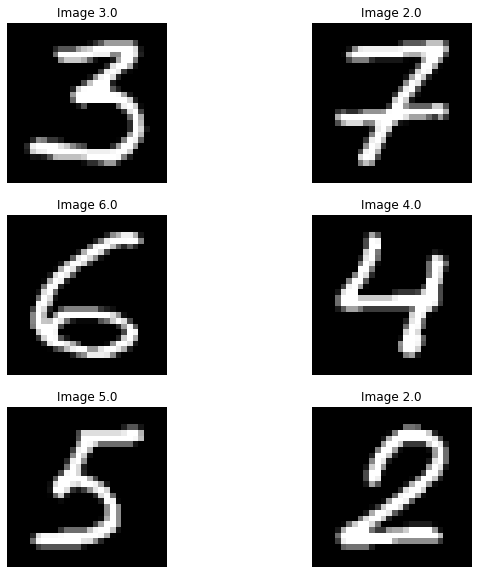

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))  

for i, ax in enumerate(axes.ravel()):
    if i < batch_size:
        x = input_array[i]
        ax.imshow(x.reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title(f"Image {output_numbers[i][0]}")
    else:
        ax.imshow(np.zeros((28, 28)), cmap='gray')
        ax.axis('off')
plt.show()

## On-board validation
Run throughput test as well as validation script

In [10]:
!python3 driver.py --exec_mode="throughput_test" --batchsize=1000

Results written to nw_metrics.txt


In [11]:
!cat nw_metrics.txt

{'runtime[ms]': 2.781391143798828, 'throughput[images/s]': 359532.3161323504, 'DRAM_in_bandwidth[MB/s]': 281.8733358477627, 'DRAM_out_bandwidth[MB/s]': 0.3595323161323504, 'fclk[mhz]': 99.999, 'batch_size': 1000, 'fold_input[ms]': 0.07319450378417969, 'pack_input[ms]': 0.08559226989746094, 'copy_input_data_to_device[ms]': 1.2619495391845703, 'copy_output_data_from_device[ms]': 0.13017654418945312, 'unpack_output[ms]': 0.45180320739746094, 'unfold_output[ms]': 0.05841255187988281}

In [12]:
!python3 validate.py

batch 1 / 10 : total OK 978 NOK 22
batch 2 / 10 : total OK 1940 NOK 60
batch 3 / 10 : total OK 2909 NOK 91
batch 4 / 10 : total OK 3878 NOK 122
batch 5 / 10 : total OK 4845 NOK 155
batch 6 / 10 : total OK 5830 NOK 170
batch 7 / 10 : total OK 6817 NOK 183
batch 8 / 10 : total OK 7813 NOK 187
batch 9 / 10 : total OK 8803 NOK 197
batch 10 / 10 : total OK 9777 NOK 223
Final accuracy: 97.770000
